In [2]:
#imports
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import pychemia
from pyprocar import ProcarSelect,ProcarParser,UtilsProcar
import pyprocar
import re
import numpy as np
import sys

This function applies lattice translations and boundary conditions to gamma-centered points to add missing points.

In [3]:
def fixGamma(kpoints, bands, spd, rec_lattice):
    klist = kpoints.tolist()
    bandlist = bands.tolist()
    spdlist = spd.tolist()
    
    #for each reciprocal lattice vector
    for i in np.arange(0,3):
        #for each kpoint
        for j,_ in enumerate(kpoints):
            #add each lattice translation
            trans_point_vec = kpoints[j] + rec_lattice[i]
            #apply boundary conditions
            bound_ops = -1.0*(trans_point_vec > 0.5) + 1.0*(trans_point_vec < -0.5)
            trans_point_vec += bound_ops
            trans_point = trans_point_vec.tolist()
            
            if trans_point not in klist:
                klist.append(trans_point)
                bandlist.append(bandlist[j])
                spdlist.append(spdlist[j])
    
    return np.array(klist), np.array(bandlist), np.array(spdlist)
            

This function parses each symmetry operation used by VASP.

In [4]:
def outcarParse_Operators(outcar):
    with open(outcar) as f:
        txt = f.readlines()

    for i,line in enumerate(txt):
        if 'irot' in line:
            begin_table = i+1
        if 'Subroutine' in line:
            end_table = i-1

    operators = np.zeros((end_table-begin_table, 9))
    for i,line in enumerate(txt[begin_table:end_table]):
        str_list = line.split()
        num_list = [float(s) for s in str_list]
        operator = np.array(num_list)
        operators[i,:] = operator
    
    return operators

This converts the symmetry operations from the form of $\begin{pmatrix}u_{x}\\u_{y}\\u_{z}\end{pmatrix}$, $\theta$, det(A) to rotation matrices.

In [94]:
#finds rotation matrix from axis vector (normalized) and angle
def findR(operator):
    det_A = operator[1]
    #convert alpha to radians
    alpha = np.pi*operator[2]/180.
    #get rotation axis
    x = operator[3]
    y = operator[4]
    z = operator[5]
        
    R = np.array([
        [np.cos(alpha) + x**2*(1-np.cos(alpha)), x*y*(1-np.cos(alpha))-z*np.sin(alpha), x*z*(1-np.cos(alpha)) + y*np.sin(alpha)],
        [y*x*(1-np.cos(alpha)) + z*np.sin(alpha), np.cos(alpha) + y**2*(1-np.cos(alpha)), y*z*(1-np.cos(alpha)) - x*np.sin(alpha)],
        [z*x*(1-np.cos(alpha)) - y*np.sin(alpha), z*y*(1-np.cos(alpha)) + x*np.sin(alpha), np.cos(alpha) + z**2*(1-np.cos(alpha))]
    ])*det_A
    
    R = np.dot(np.dot(np.linalg.inv(reciprocal_lattice), R), reciprocal_lattice)
    R = np.round_(R, decimals=3)

    #get translation
    #t = np.array(operator[6:])
    
    return R

This function applies each symmetry operation to each kpoint.

In [6]:
def just_apply_symmetries(kpoints):
    klist = []
    bandlist = []
    spdlist = []
    #for each symmetry operation
    for i,_ in enumerate(rotations): 
        #RU = np.dot(rotations[i],reciprocal_lattice)
        #for each point
        for j,_ in enumerate(kpoints):
            #apply symmetry operation to kpoint
            sympoint_vector = np.dot(rotations[i], kpoints[j])
            sympoint = sympoint_vector.tolist()
            
            if sympoint not in klist:
                klist.append(sympoint)

                band = bands_sym[j].tolist()
                bandlist.append(band)
                spd = spd_sym[j].tolist()
                spdlist.append(spd)
            
    new_kpoints = np.array(klist)
    new_bands = np.array(bandlist)
    new_spd = np.array(spdlist)
    
    return new_kpoints, new_bands, new_spd

In [7]:
#repair files
pyprocar.repair('PROCAR-MgB2-Monkhorst_sym','PROCAR-MgB2-Monkhorst_sym')
pyprocar.repair('PROCAR-MgB2-Monkhorst_nosym','PROCAR-MgB2-Monkhorst_nosym')
pyprocar.repair('OUTCAR-MgB2-Monkhorst','OUTCAR-MgB2-Monkhorst')

 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 5.4.0 created on June 17th, 2020

Please cite: Herath, U., Tavadze, P., He, X., Bousquet, E., Singh, S., Muñoz, F. & Romero,    A., PyProcar: A Python library for electronic structure pre/post-processing.,    Computer Physics Communications 251 (2020):107080.

Input File    :  PROCAR-MgB2-Monkhorst_sym
Output File   :  PROCAR-MgB2-Monkhorst_sym
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 5.4.0 created on June 17th, 2020

Please cite: Herath, U., Tavadze, P., He, X., Bousquet, E.,

Call the files and get the symmetry operations.

In [95]:
#get symops
procar_nosym = 'PROCAR-MgB2-Monkhorst_nosym'
procar_sym = 'PROCAR-MgB2-Monkhorst_sym'

operators = outcarParse_Operators('OUTCAR-MgB2-Monkhorst')
rotations = np.array([findR(operator) for operator in operators])

"""
rf = open('OUTCAR','r')
outcar = rf.read()
rf.close()


structure = pychemia.code.vasp.read_poscar('POSCAR_Al')
cs = pychemia.crystal.CrystalSymmetry(structure)
#3x3 matrices to multiply
rotations = cs.get_symmetry()['rotations']

#3x1 vector to add
translations = cs.get_symmetry()['translations']
symmetry_vasp = re.findall('point\s*symmetry\s*([A-Z][_a-z0-9]*)',outcar)[0].strip().replace('_','') # THis is the symmetry recognized by the dft code
symmetry_spglib  = cs.get_space_group_type()['pointgroup_international'] # symmetry found by spglib
# These two should be the same symmetry_vasp,symmetry_spg. We might want to check in the future
print(symmetry_vasp,symmetry_spglib)
"""

"\nrf = open('OUTCAR','r')\noutcar = rf.read()\nrf.close()\n\n\nstructure = pychemia.code.vasp.read_poscar('POSCAR_Al')\ncs = pychemia.crystal.CrystalSymmetry(structure)\n#3x3 matrices to multiply\nrotations = cs.get_symmetry()['rotations']\n\n#3x1 vector to add\ntranslations = cs.get_symmetry()['translations']\nsymmetry_vasp = re.findall('point\\s*symmetry\\s*([A-Z][_a-z0-9]*)',outcar)[0].strip().replace('_','') # THis is the symmetry recognized by the dft code\nsymmetry_spglib  = cs.get_space_group_type()['pointgroup_international'] # symmetry found by spglib\n# These two should be the same symmetry_vasp,symmetry_spg. We might want to check in the future\nprint(symmetry_vasp,symmetry_spglib)\n"

In [96]:
np.set_printoptions(threshold=sys.maxsize)
print(rotations)

[[[ 1.  0.  0.]
  [ 0.  1.  0.]
  [-0.  0.  1.]]

 [[-1.  0.  0.]
  [ 0. -1.  0.]
  [ 0.  0. -1.]]

 [[ 1.  0.  1.]
  [ 0.  1.  0.]
  [-1.  0.  0.]]

 [[-1.  0. -1.]
  [ 0. -1.  0.]
  [ 1.  0. -0.]]

 [[-0.  0.  1.]
  [ 0.  1.  0.]
  [-1.  0. -1.]]

 [[ 0.  0. -1.]
  [ 0. -1.  0.]
  [ 1.  0.  1.]]

 [[-1.  0.  0.]
  [ 0.  1.  0.]
  [-0.  0. -1.]]

 [[ 1.  0. -0.]
  [ 0. -1.  0.]
  [ 0.  0.  1.]]

 [[-1.  0. -1.]
  [ 0.  1.  0.]
  [ 1.  0. -0.]]

 [[ 1.  0.  1.]
  [ 0. -1.  0.]
  [-1.  0.  0.]]

 [[ 0.  0. -1.]
  [ 0.  1.  0.]
  [ 1.  0.  1.]]

 [[-0.  0.  1.]
  [ 0. -1.  0.]
  [-1.  0. -1.]]

 [[ 1.  0.  0.]
  [-0. -1. -0.]
  [-1.  0. -1.]]

 [[-1.  0.  0.]
  [ 0.  1.  0.]
  [ 1. -0.  1.]]

 [[-0.  0. -1.]
  [-0. -1. -0.]
  [-1.  0. -0.]]

 [[ 0. -0.  1.]
  [ 0.  1.  0.]
  [ 1. -0.  0.]]

 [[-1.  0. -1.]
  [-0. -1. -0.]
  [-0.  0.  1.]]

 [[ 1. -0.  1.]
  [ 0.  1.  0.]
  [ 0. -0. -1.]]

 [[-1. -0.  0.]
  [ 0. -1.  0.]
  [ 1.  0.  1.]]

 [[ 1.  0.  0.]
  [-0.  1.  0.]
  [-1. -0. -1.]]



This cell will check if a certain matrix listed on the BCS was calculated with our function. For Si it turns out that the matrices match perfectly.

In [10]:
bilbao_matrix = np.array([
    [0,0,1],
    [0,1,0],
    [1,0,0]
])
bilbao_check = np.any(np.array([np.all(R == bilbao_matrix) for R in rotations]))
print(bilbao_check)

False


Parse the kpoints from the VASP runs with and without symmetry.

In [64]:
#get kpoints
np.set_printoptions(threshold=sys.maxsize)
outcarparser = UtilsProcar()

#parse reciprocal lattice matrix
reciprocal_lattice = np.transpose(outcarparser.RecLatOutcar('OUTCAR-MgB2-Monkhorst'))

procarFile = ProcarParser()
procarFile.readFile(procar_nosym, False)
data_nosym = ProcarSelect(procarFile, deepCopy=True)
frac_kpoints_nosym = data_nosym.kpoints

procarFile = ProcarParser()
procarFile.readFile(procar_sym, False)
data_sym = ProcarSelect(procarFile, deepCopy=True)
frac_kpoints_sym = data_sym.kpoints
bands_sym = data_sym.bands
spd_sym = data_sym.spd

#frac_kpoints_sym, bands_sym, spd_sym = fixGamma(frac_kpoints_sym, bands_sym, spd_sym, reciprocal_lattice)

spd shape      :  (8000, 32, 4, 4, 11) [kpoints, bands, spins, atoms+1, orbitals+2]
spd shape      :  (1100, 16, 1, 4, 11) [kpoints, bands, spins, atoms+1, orbitals+2]


Apply symmetry operations and boundary conditions... remove repeated points.

In [97]:
kpoints_calculated_frac, bands_calculated, spd_calculated = just_apply_symmetries(frac_kpoints_sym)
bound_ops = -1.0*(kpoints_calculated_frac > 0.5) + 1.0*(kpoints_calculated_frac < -0.5)
kpoints_calculated_frac += bound_ops
#kpoints_unique = np.unique(kpoints_calculated_frac, axis=0)

In [98]:
print(kpoints_calculated_frac, kpoints_calculated_frac.shape)

[[ 0.025  0.025  0.025]
 [ 0.075  0.025  0.025]
 [ 0.125  0.025  0.025]
 [ 0.175  0.025  0.025]
 [ 0.225  0.025  0.025]
 [ 0.275  0.025  0.025]
 [ 0.325  0.025  0.025]
 [ 0.375  0.025  0.025]
 [ 0.425  0.025  0.025]
 [ 0.475  0.025  0.025]
 [-0.475  0.025  0.025]
 [-0.425  0.025  0.025]
 [-0.375  0.025  0.025]
 [-0.325  0.025  0.025]
 [-0.275  0.025  0.025]
 [-0.225  0.025  0.025]
 [-0.175  0.025  0.025]
 [-0.125  0.025  0.025]
 [-0.075  0.025  0.025]
 [-0.025  0.025  0.025]
 [ 0.025  0.075  0.025]
 [ 0.075  0.075  0.025]
 [ 0.125  0.075  0.025]
 [ 0.175  0.075  0.025]
 [ 0.225  0.075  0.025]
 [ 0.275  0.075  0.025]
 [ 0.325  0.075  0.025]
 [ 0.375  0.075  0.025]
 [ 0.425  0.075  0.025]
 [ 0.475  0.075  0.025]
 [-0.475  0.075  0.025]
 [-0.425  0.075  0.025]
 [-0.375  0.075  0.025]
 [-0.325  0.075  0.025]
 [-0.275  0.075  0.025]
 [-0.225  0.075  0.025]
 [-0.175  0.075  0.025]
 [-0.125  0.075  0.025]
 [-0.075  0.075  0.025]
 [-0.025  0.075  0.025]
 [ 0.025  0.125  0.025]
 [ 0.075  0.125 

This counts how many incorrect points were found (false positives) and how many correct points were missed (misses) to help troubleshoot. 

In [ ]:
#check errors
misses = 0
false_positives = 0
for point in frac_kpoints_nosym.tolist():
    if point not in kpoints_unique.tolist():
        misses += 1
        
for point in kpoints_unique.tolist():
    if point not in frac_kpoints_nosym.tolist():
        false_positives += 1

In [ ]:
print(misses, false_positives)

Make a 3D plot of the kpoint grid.

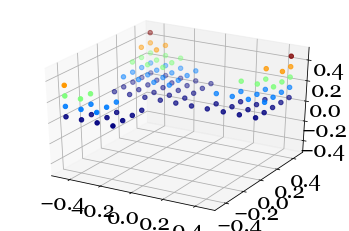

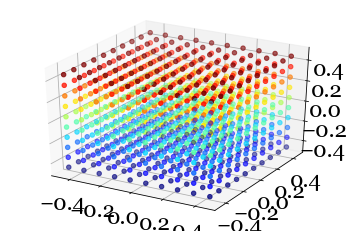

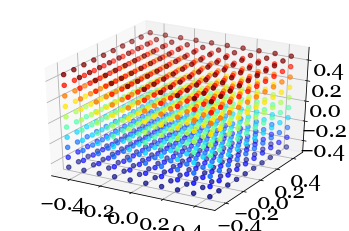

In [52]:
matplotlib.use( 'tkagg' )
w = frac_kpoints_nosym 
v = frac_kpoints_sym
u = kpoints_unique
#needed = np.array([point for point in w if point not in u])
fig = plt.figure('symmetry')
ax = fig.add_subplot(111, projection='3d')
#ax.scatter3D(w[:,0], w[:,1], w[:,2], c='red')#, cmap='jet')
ax.scatter3D(v[:,0], v[:,1], v[:,2],c=v[:,2],cmap='jet')#, cmap='jet')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
plt.show()
fig = plt.figure('No symmetry')
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(w[:,0], w[:,1], w[:,2], c=w[:,2], cmap='jet')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
fig = plt.figure('calculated')
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(u[:,0], u[:,1], u[:,2], c=u[:,2], cmap='jet')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
#fig = plt.figure('Missing')
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter3D(needed[:,0], needed[:,1], needed[:,2], c=needed[:,2], cmap='jet')
#ax.set_xlim(-0.5,0.5)
#ax.set_ylim(-0.5,0.5)
#ax.set_zlim(-0.5,0.5)
plt.show()


Make a 2D plot at a certain z-value, e.g. z = 0.11111111

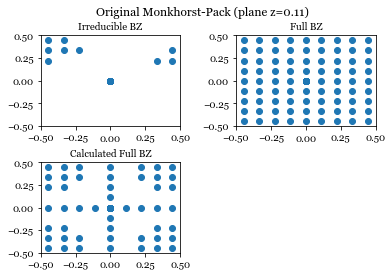

In [18]:
np.set_printoptions(threshold=sys.maxsize)
z = 0.11111111
wx = frac_kpoints_nosym[:,0]*(frac_kpoints_nosym[:,2] == z)
wy = frac_kpoints_nosym[:,1]*(frac_kpoints_nosym[:,2] == z)
vx = frac_kpoints_sym[:,0]*(frac_kpoints_sym[:,2] == z)
vy = frac_kpoints_sym[:,1]*(frac_kpoints_sym[:,2] == z)
ux = kpoints_calculated_frac[:,0]*(kpoints_calculated_frac[:,2] == z)
uy = kpoints_calculated_frac[:,1]*(kpoints_calculated_frac[:,2] == z)

fig = plt.figure('Gamma-centered Monkhorst-Pack')
fig.suptitle('Original Monkhorst-Pack (plane z=0.11)',fontsize=12)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

ax1 = fig.add_subplot(221)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.scatter(vx,vy)
ax1.set_xlim(-0.5,0.5)
ax1.set_ylim(-0.5,0.5)
ax1.set_title('Irreducible BZ',fontsize=10)

ax2 = fig.add_subplot(222)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.scatter(wx,wy)
ax2.set_xlim(-0.5,0.5)
ax2.set_ylim(-0.5,0.5)
ax2.set_title('Full BZ',fontsize=10)

ax3 = fig.add_subplot(223)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.scatter(ux,uy)
ax3.set_xlim(-0.5,0.5)
ax3.set_ylim(-0.5,0.5)
ax3.set_title('Calculated Full BZ',fontsize=10)

plt.show()